In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import os
from tqdm import tqdm
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### CIFAKE Training and Evaluation

In [3]:
train_dataset = datasets.ImageFolder(root='../data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.ImageFolder(root='../data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Classes:', train_dataset.classes)

Train dataset size: 100000
Test dataset size: 20000
Classes: ['FAKE', 'REAL']


In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(64 * 56 * 56, 2)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

In [5]:
model = models.resnet50(pretrained=True)

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\adity/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 32.7MB/s]


In [6]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)

In [7]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [8]:
for e in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for img, label in tepoch:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss/len(train_loader))

100%|██████████| 1563/1563 [05:04<00:00,  5.13batch/s, loss=0.221]


In [9]:
os.makedirs('saved_models', exist_ok=True)
torch.save(model.state_dict(), 'saved_models/resnet50_model.pth')

In [10]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, unit="batch"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs.data, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 313/313 [00:59<00:00,  5.24batch/s]


In [11]:
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification report:")
print(classification_report(all_labels, all_preds))

Accuracy: 0.9214
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10000
           1       0.91      0.93      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



Confusion matrix:
[[9117  883]
 [ 689 9311]]


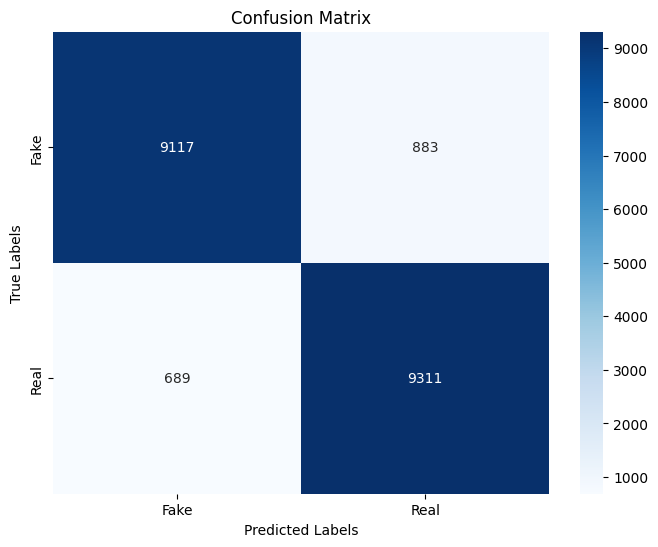

In [12]:
cm = confusion_matrix(all_labels, all_preds)
print('Confusion matrix:')
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'], va='center')
plt.show()

### FakeNet Evaluation

In [16]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('saved_models/resnet50_model.pth'))
model = model.to(device)
model.eval()

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
test_dataset = datasets.ImageFolder(root='../FakeNet', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
print('Test dataset size:', len(test_dataset))
print('Classes:', test_dataset.classes)

Test dataset size: 9990
Classes: ['FAKE', 'REAL']


In [19]:
# model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, unit="batch"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs.data, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 157/157 [02:27<00:00,  1.07batch/s]


In [21]:
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification report:")
print(classification_report(all_labels, all_preds))

Accuracy: 0.5094094094094094
Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4990
           1       0.90      0.02      0.04      5000

    accuracy                           0.51      9990
   macro avg       0.70      0.51      0.36      9990
weighted avg       0.70      0.51      0.36      9990



Confusion matrix:
[[4977   13]
 [4888  112]]


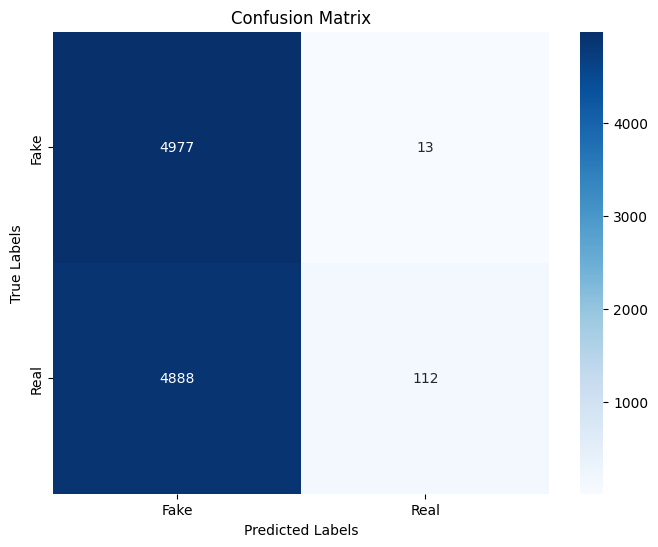

In [22]:
cm = confusion_matrix(all_labels, all_preds)
print('Confusion matrix:')
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'], va='center')
plt.show()